In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
!git-lfs --version

git-lfs/2.10.0 (GitHub; linux amd64; go 1.17.12)


In [3]:
from dataclasses import dataclass

In [4]:
import torch

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.__version__

'1.12.0'

In [7]:
torch.__path__

['/usr/local/pace-apps/manual/packages/pytorch/1.12.0/lib/python3.9/site-packages/torch']

In [8]:
@dataclass
class TrainingConfig:
    image_size = 128
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    sava_model_epochs = 30
    mixed_precision = 'fp16'
    output_dir = "ddpm-butterflies-128"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()

In [9]:
import numpy as np
print(np.__version__)

1.22.3


In [10]:
!conda list | grep datasets

datasets                  2.17.1             pyhd8ed1ab_0    conda-forge


In [11]:
import datasets
from datasets import load_dataset

In [12]:
from datasets import load_dataset
config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split='train')

Repo card metadata block was not found. Setting CardData to empty.


In [13]:
type(dataset)

datasets.arrow_dataset.Dataset

In [14]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

In [19]:
# # import h5py
# # with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64.h5") as f:
# #     print(f.keys())
# #     print(f['params_seeds']['values'])
# #     dataset = f['brightness_temp'][:4]
# #     params = np.array(f['params_seeds']['values'])
# # dataset[:4]['image']
# dataset.shape
# # params.shape
# import matplotlib.pyplot as plt
# plt.scatter(params[:,0], params[:,1], s=0.1)
# _ = plt.hist(params[:,2],bins=100)
# np.unique(params[:,2]).shape
# params[:5,2].astype(int)
# params[:5,:2].astype(np.float64)

# fig, axs = plt.subplots(4,1)#,figsize=(16,4),dpi=100)
# for i, image in enumerate(dataset):
#     axs[i].imshow(image[0])
#     axs[i].set_axis_off()
#     axs[i].set_title(params[i][:2])
# fig.show()
# plt.tight_layout()

In [24]:
dataset.shape

(1000, 18)

In [25]:
dataset[0]

{'image_url': 'https://ids.si.edu/ids/deliveryService?id=ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6',
 'image_alt': 'view Paper Kite digital asset number 1',
 'id': 'ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6',
 'name': 'Paper Kite',
 'scientific_name': 'Idea leuconoe',
 'gender': None,
 'taxonomy': 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae',
 'region': 'US Mid Atlantic (PA, NJ, MD, DE, DC, VA, WV)',
 'locality': 'NMNH Butterfly Pavilion, North America, United States, District of Columbia',
 'date': None,
 'usnm_no': 'EO401041',
 'guid': 'http://n2t.net/ark:/65665/35f90bc1d-2e3c-4798-a33c-611d7b358636',
 'edan_url': 'edanmdm:nmnheducation_11038234',
 'source': 'Smithsonian Education and Outreach collections',
 'stage': None,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x283>,
 'image_hash': 'fb0b8749d437efc70a26e54212b3572c',
 'sim_score': 0.8055200576782227}

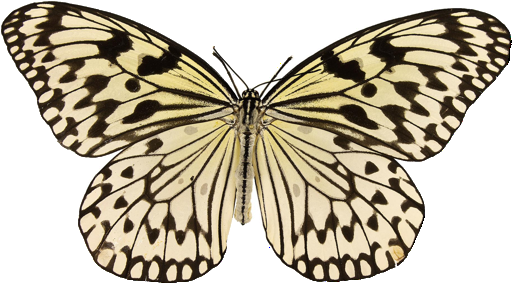

In [16]:
dataset[:4]['image'][0]

In [21]:
import numpy as np
image = dataset[:4]['image'][0]
image_array = np.array(image)

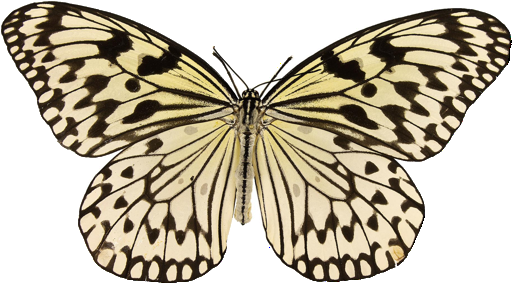

In [18]:
dataset['image'][0]

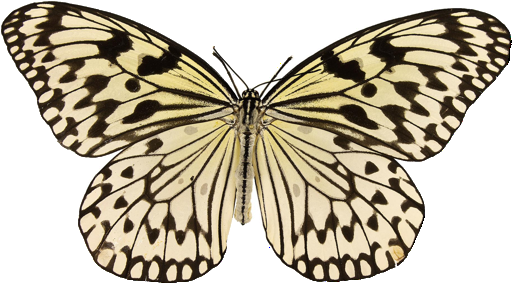

In [19]:
dataset[0]['image']

In [22]:
type(image_array)

numpy.ndarray

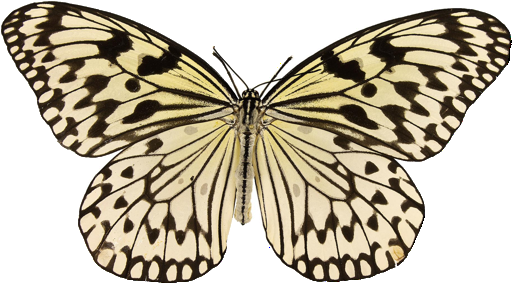

In [23]:
image

In [24]:
image_array.max()

255

In [25]:
image_array.min()

0

In [26]:
from torchvision import transforms
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]
)

In [27]:
type(dataset[:4]['image'][0])

PIL.PngImagePlugin.PngImageFile

In [28]:
np.min(dataset[:4]['image'][0])

0

In [29]:
np.max(dataset[:4]['image'][0])

255

In [30]:
type(dataset[:4]['image'][0].convert("RGB"))

PIL.Image.Image

In [31]:
np.min(dataset[:4]['image'][0].convert("RGB"))

0

In [32]:
np.max(dataset[:4]['image'][0].convert("RGB"))

255

In [34]:
type(dataset)

datasets.arrow_dataset.Dataset

In [35]:
dataset.shape

(1000, 18)

In [36]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    # print(np.shape(images))
    # print(np.max(images))
    # print(np.min(images))
    return {"images": images}

dataset.set_transform(transform)

In [49]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

In [50]:
type(dataset)

datasets.arrow_dataset.Dataset

In [51]:
dataset.shape

(1000, 18)

In [52]:
images = dataset[:4]['images']
np.shape(images)

/usr/local/pace-apps/manual/packages/pytorch/1.12.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/usr/local/pace-apps/manual/packages/pytorch/1.12.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(4,)

In [63]:
dataset[0]['images'].shape

torch.Size([3, 128, 128])

In [65]:
images[0].shape

torch.Size([3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


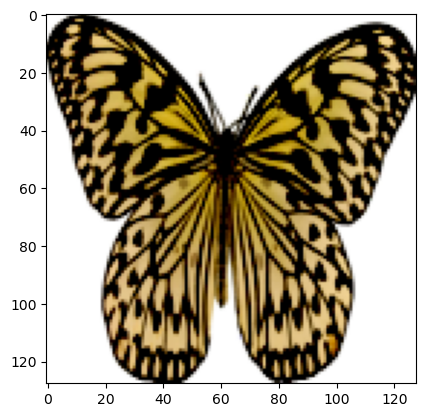

In [66]:
import matplotlib.pyplot as plt
plt.imshow(images[0].permute((1,2,0)))

In [67]:
images[0].min()

tensor(-0.9529)

In [68]:
images[0].max()

tensor(1.)

In [69]:
import torch
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [70]:
train_dataloader

In [71]:
len(train_dataloader)

63

In [74]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size = config.image_size,
    in_channels = 3,
    out_channels = 3,
    layers_per_block = 2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D',
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

In [78]:
dataset[0]['images'].shape

torch.Size([3, 128, 128])

In [79]:
sample_image = dataset[0]['images'].unsqueeze(0)

In [80]:
sample_image.shape

torch.Size([1, 3, 128, 128])

In [87]:
output = model(sample_image, timestep=0).sample

In [88]:
output.shape

torch.Size([1, 3, 128, 128])

In [93]:
output.max()

tensor(1.2841, grad_fn=<MaxBackward1>)

In [94]:
output.min()

tensor(-1.3978, grad_fn=<MinBackward1>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


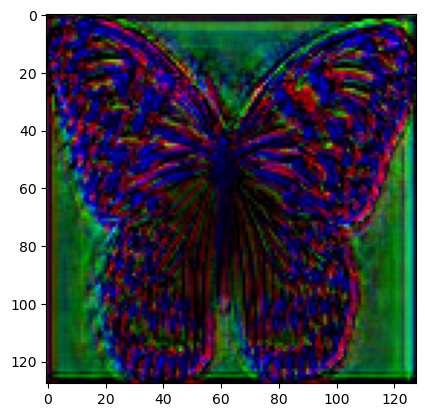

In [92]:
plt.imshow(output[0].permute(1,2,0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


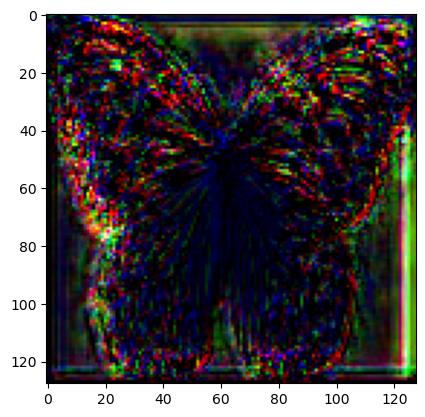

In [95]:
output = model(output, timestep=0).sample
plt.imshow(output[0].permute(1,2,0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


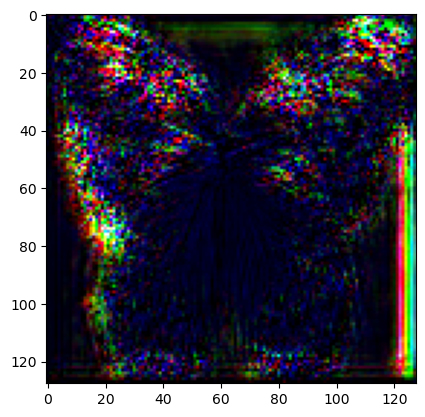

In [96]:
output = model(output, timestep=0).sample
plt.imshow(output[0].permute(1,2,0).detach().numpy())

In [97]:
sample_image.shape

torch.Size([1, 3, 128, 128])

In [98]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])

In [100]:
timesteps

tensor([50])

In [101]:
timesteps.shape

torch.Size([1])

In [102]:
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

In [103]:
noisy_image.shape

torch.Size([1, 3, 128, 128])

In [106]:
sample_image.min()

tensor(-0.9529)

In [108]:
sample_image.max()

tensor(1.)

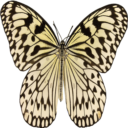

In [117]:
Image.fromarray((127.5*(sample_image.permute(0,2,3,1) + 1)).type(torch.uint8).numpy()[0])

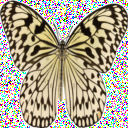

In [128]:
Image.fromarray((127.5*(noise_scheduler.add_noise(sample_image, noise, torch.LongTensor([0])).permute(0,2,3,1) + 1)).type(torch.uint8).numpy()[0])

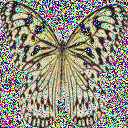

In [118]:
Image.fromarray((127.5*(noisy_image.permute(0,2,3,1) + 1)).type(torch.uint8).numpy()[0])

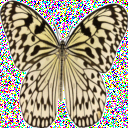

In [121]:
Image.fromarray((127.5*(noise_scheduler.add_noise(sample_image, noise, torch.LongTensor([1])).permute(0,2,3,1) + 1)).type(torch.uint8).numpy()[0])

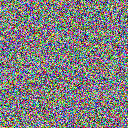

In [123]:
Image.fromarray((127.5*(noise_scheduler.add_noise(sample_image, noise, torch.LongTensor([999])).permute(0,2,3,1) + 1)).type(torch.uint8).numpy()[0])

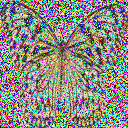

In [126]:
Image.fromarray((127.5*(noise_scheduler.add_noise(sample_image, noise, torch.LongTensor([100])).permute(0,2,3,1) + 1)).type(torch.uint8).numpy()[0])

In [129]:
timesteps

tensor([50])

In [131]:
import torch.nn.functional as F
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [132]:
loss

tensor(1.0886, grad_fn=<MseLossBackward0>)

In [133]:
noise_pred.shape

torch.Size([1, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


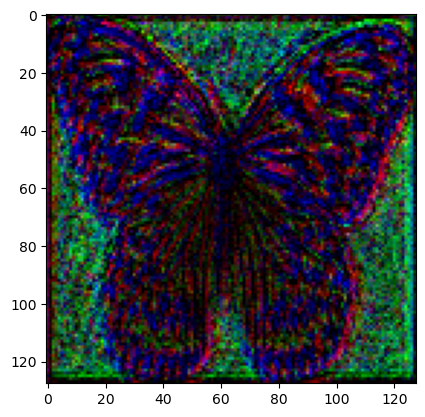

In [135]:
plt.imshow(noise_pred[0].permute(1,2,0).detach())

In [136]:
noise.shape

torch.Size([1, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


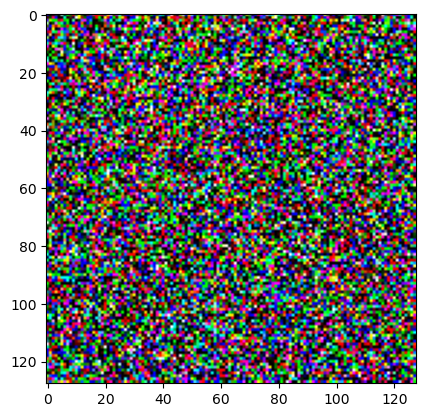

In [138]:
plt.imshow(noise[0].permute(1,2,0))

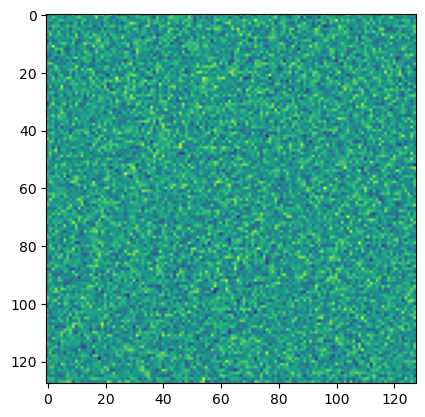

In [139]:
plt.imshow(noise[0][0])

In [140]:
from accelerate import Accelerator, notebook_launcher

In [141]:
model.parameters()

<generator object Module.parameters at 0x2aabbad933c0>

In [142]:
config.learning_rate

0.0001

In [143]:
from diffusers.optimization import get_cosine_schedule_with_warmup

In [145]:
len(train_dataloader) * config.num_epochs

3150

In [146]:
(len(train_dataloader) * config.num_epochs)

3150

In [147]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = len(train_dataloader) * config.num_epochs,
)

In [151]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

In [152]:
def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')

In [153]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.get_device_name(0)

'Quadro RTX 6000'

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
train_ds_normalized = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
        )
train_ds_unnormalized = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),]))

In [6]:
batch_size = 200
# train_loader = torch.utils.data.DataLoader(
#     train_ds_normalized, batch_size=batch_size, shuffle=True,
# )
train_loader = torch.utils.data.DataLoader(train_ds_unnormalized, shuffle=True, batch_size=batch_size)

shape_nor = torch.Size([6000, 1, 28, 28])
shape_unn = torch.Size([6000, 1, 28, 28])


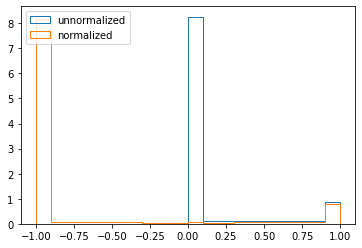

In [7]:
images_normalized, _ = next(iter(torch.utils.data.DataLoader(train_ds_normalized, shuffle=True, batch_size=6000)))
images_unnormal, _ = next(iter(torch.utils.data.DataLoader(train_ds_unnormalized, shuffle=True, batch_size=6000)))
print("shape_nor =", images_normalized.shape)
print("shape_unn =", images_unnormal.shape)
plt.hist(images_unnormal.numpy().reshape(-1), label="unnormalized", density=True, bins=10, histtype="step")
plt.hist(images_normalized.numpy().reshape(-1), label="normalized", density=True, bins=20, histtype="step")
plt.legend()
plt.show()
# plt.imshow(np.transpose(images[0], axes=(1,2,0)), cmap="gray")

In [42]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

model = Unet(
    dim = 64,
    dim_mults = (1,2,4),
    channels = 1
).to(device)

diffusion = GaussianDiffusion(
    model,
    objective = "pred_noise",
    image_size = 28,
    timesteps = 500,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

def plt_sampled_images(savefig="diffusion_epoch.png"):
    sampled_images = diffusion.sample(64).cpu()
    sampled_images = sampled_images.reshape(8,8,1,28,28)
    fig, ax = plt.subplots(8,8, figsize=(8,8), dpi=200, constrained_layout=True)
    fig.suptitle(f"epoch {epoch:03d}/{num_epochs:03d}; step {step:03d}")
    for i in range(8):
        for j in range(8):
            # ax = plt.subplot(4,4,i+1)
            ax[i][j].imshow(np.transpose(sampled_images[i][j], axes=(1,2,0)), 
    cmap = 'gray')
            ax[i][j].axis('off')
            # ax[i][j].set_xticks([])
            # ax[i][j].set_yticks([])
    # plt.tight_layout()
    if savefig != False:
        plt.savefig(savefig)
        plt.close()

In [43]:
num_epochs = 20
for epoch in range(num_epochs):
    start_time = time.time()
    for step, (mnist_images, mnist_labels) in enumerate(train_loader):
        mnist_images = mnist_images.to(device=device)
        optimizer.zero_grad()
        loss = diffusion(mnist_images).to(device)
        loss.backward()
        optimizer.step()
        # if epoch == 0 and step % 5 == 0:
        #     plt_sampled_images(f"diffusion_step{step:03d}.png")
    end_time = time.time()
    print(f"Epoch: {epoch}, {batch_size} batches, {step+1} steps, cost {end_time-start_time:.3f} sec, Loss.: {loss}")
    
    plt_sampled_images(f"diffusion_epoch{epoch:03d}.png")

torch.save(model.state_dict(), "diffusion.pt")


KeyboardInterrupt: 